In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel('data_full_5sekres.xlsx')

In [3]:
df1 = df.copy()

In [4]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1.loc[df1['operationId'] == 100, 'BaseLoad'] = 500
df1.loc[df1['operationId'] == 3, 'BaseLoad'] = 550
df1.loc[df1['operationId'] == 5, 'BaseLoad'] = 510
df1.loc[df1['operationId'] == 6, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 1, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 7, 'BaseLoad'] = 380
df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


display(df3)

,datetime,Load,engMdoPower_0_,engMdoPower_1_,engMdoPower_2_,engMdoPower_3_,operationId,BaseLoad,Battery,SOC
0,2020-01-30 00:00:00,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
1,2020-01-30 00:00:05,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
2,2020-01-30 00:00:10,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
3,2020-01-30 00:00:15,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
4,2020-01-30 00:00:20,250.0,0.0,0.0,0,0.0,6.0,250.0,0,0
...,...,...,...,...,...,...,...,...,...,...
120955,2020-02-05 23:59:35,2046.0,0.0,0.0,0,0.0,3.0,550.0,0,0
120956,2020-02-05 23:59:40,1993.2,0.0,0.0,0,0.0,3.0,550.0,0,0
120957,2020-02-05 23:59:45,1975.6,0.0,0.0,0,0.0,3.0,550.0,0,0
120958,2020-02-05 23:59:50,2010.8,0.0,0.0,0,0.0,3.0,550.0,0,0


# No shore connection, 20% battery at start

In [22]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%)
opid = df5['operationId'].values

for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and opid[i] != 6: 
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]*1.08
        soc[i+1] = soc[i] - bat[i]/720
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]

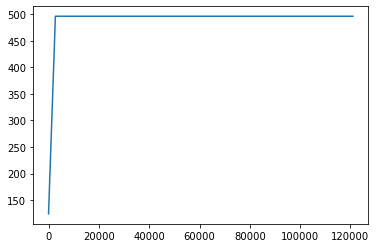

In [23]:
plt.plot(soc)

In [24]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

len(dg0)
type(dg0)

numpy.ndarray

In [25]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [26]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of BASECASE med batteri kun til spinning reserve og 20% batteri start er: ', fc, 'liter')

Total fuel consumption of BASECASE med batteri kun til spinning reserve og 20% batteri start er:  44593.20843008009 liter


# No shore connection, 80% battery at start

In [27]:
df6 = df3.copy()

load = df6['Load'].values
dg0 = df6['engMdoPower_0_'].values
dg1 = df6['engMdoPower_1_'].values
dg2 = df6['engMdoPower_2_'].values
dg3 = df6['engMdoPower_3_'].values
bat = df6['Battery'].values
soc = [0]*120960
soc[0] = 496 #124 empty (20%)
opid = df6['operationId'].values

for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and opid[i] != 6: 
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]*1.08
        soc[i+1] = soc[i] - bat[i]/720
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]

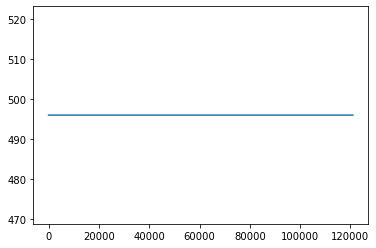

In [28]:
plt.plot(soc)

In [29]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

len(dg0)
type(dg0)

numpy.ndarray

In [30]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [31]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of BASECASE med batteri kun til spinning reserve og 80% batteri start er: ', fc, 'liter')

Total fuel consumption of BASECASE med batteri kun til spinning reserve og 80% batteri start er:  44508.05450150872 liter


# Shore connection covers hotel load at port

In [42]:
df7 = df3.copy()

load = df7['Load'].values
dg0 = df7['engMdoPower_0_'].values
dg1 = df7['engMdoPower_1_'].values
dg2 = df7['engMdoPower_2_'].values
dg3 = df7['engMdoPower_3_'].values
bat = df7['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%)
opid = df7['operationId'].values
shore = [0]*120960

for i in range(len(load)):
    if i == 120959:
        pass
    elif load[i] <= 2100 and opid[i] != 6: 
        dg0[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = - bat[i]*1.08
        shore[i] = load[i]
        soc[i+1] = soc[i] - bat[i]/720
    elif load[i] <= 2100 and opid[i] == 6 and soc[i] >= 496:
        #dg0[i] = load[i]
        shore[i] = load[i]
        soc[i+1] = soc[i]
    elif load[i] > 2100:
        dg0[i] = dg1[i] = load[i]/2
        soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]

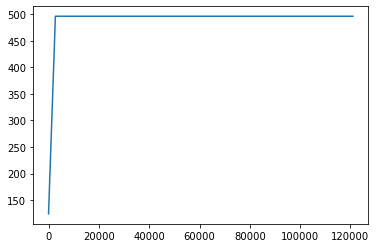

In [43]:
plt.plot(soc)

In [44]:
# Normalize Generators
dg0n = (dg0-dg0.min()) / (2100 - dg0.min())
dg1n = (dg1-dg1.min()) / (2100 - dg1.min())
dg2n = (dg2-dg2.min()) / (2100 - dg2.min())
dg3n = (dg3-dg3.min()) / (2100 - dg3.min())

len(dg0)
type(dg0)

numpy.ndarray

In [45]:
fc_dg0 = np.zeros(120960)
fc_dg1 = np.zeros(120960)
fc_dg2 = np.zeros(120960)
fc_dg3 = np.zeros(120960)

for i in range(len(dg0)):
    if dg0[i] == 0:
        fc_dg0[i] = 0
    else:
        fc_dg0[i] = (445*dg0n[i] + 47)/720
        
for i in range(len(dg1)):
    if dg1[i] == 0:
        fc_dg1[i] = 0
    else:
        fc_dg1[i] = (445*dg1n[i] + 47)/720
        
for i in range(len(dg2)):
    if dg2[i] == 0:
        fc_dg2[i] = 0
    else:
        fc_dg2[i] = (445*dg2n[i] + 47)/720
        
for i in range(len(dg3)):
    if dg3[i] == 0:
        fc_dg3[i] = 0
    else:
        fc_dg3[i] = (445*dg3n[i] + 47)/720

In [46]:
fc = sum(fc_dg0) + sum(fc_dg1) + sum(fc_dg2) + sum(fc_dg3)
print('Total fuel consumption of BASECASE med batteri kun til spinning reserve og 20% batteri start shore connection er: ', fc, 'liter')

Total fuel consumption of BASECASE med batteri kun til spinning reserve og 20% batteri start shore connection er:  40089.64959020127 liter
